In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
counts = pd.read_csv('../output/datasets/counts.csv.gz')

In [3]:
def get_abundance(df):
    df = df.query('count > 10 and rnd == 18')
    df = ((df.groupby(['core', 'pool_mod', 'sub_mod', 'rnd'])
             .agg(count=('count', np.sum))) / \
          (df.groupby(['pool_mod', 'sub_mod', 'rnd'])
             .agg(count=('count', np.sum))) * 1e6)
    df = df.groupby(level=['pool_mod', 'rnd', 'core']).agg(count=('count', np.mean))
    df = df.reset_index().pivot_table(index=['core', 'rnd'], columns=['pool_mod'], values=['count'])
    return df

In [4]:
cpms = get_abundance(counts)
cpms = cpms['count'].reset_index()
cpms = cpms.melt(id_vars=['core', 'rnd'],
                 value_vars=['C', 'm3C', 'm4C', 'm5C'], value_name='cpm').rename(columns={'pool_mod': 'sub_mod'})
cpms = cpms.loc[:, ['core', 'sub_mod', 'cpm']]

In [5]:
cleavage = pd.read_csv('../output/datasets/cleavage_filtered.csv.gz')
cleavage = cleavage.groupby(['core', 'rna', 'sub_mod']).agg(FC=('FC', np.mean),
                                                                 FC_sd=('FC', np.std), 
                                                                 N=('core', np.count_nonzero),
                                                                 pos=('pos', np.mean)).reset_index()
cleavage = cleavage.loc[:, ['core', 'rna', 'sub_mod', 'FC']]
cleavage = cleavage.groupby(['core', 'sub_mod']).agg(FC=('FC', lambda x: np.sum(x) / 4)).reset_index()

In [6]:
FC_vs_CPM = cleavage.join(cpms.set_index(['core', 'sub_mod']), on=['core', 'sub_mod'], how='inner')

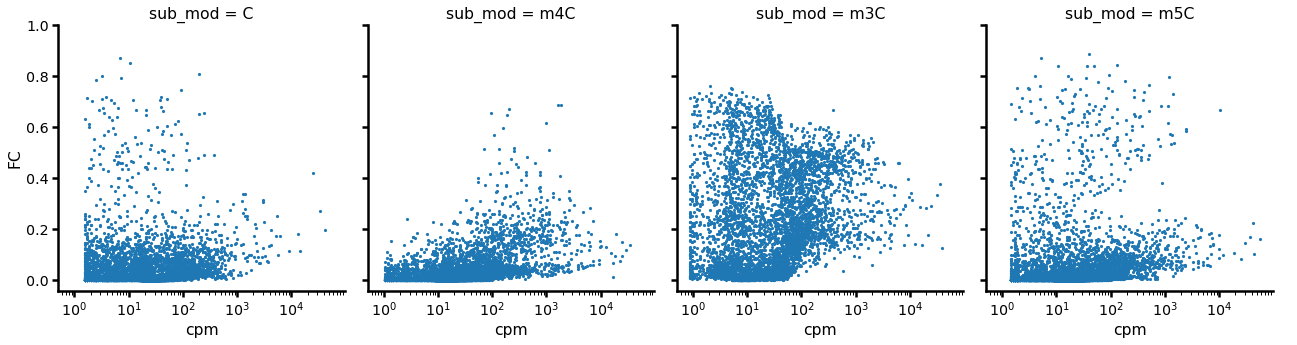

In [7]:
sns.set_context("notebook", font_scale=1.3, rc={"axes.linewidth": 2.5,
                                               "xtick.major.width": 2.5,
                                               "ytick.major.width": 2.5})
g = sns.FacetGrid(FC_vs_CPM, col='sub_mod', height=5, aspect=0.9)
g.map_dataframe(sns.scatterplot, x='cpm', y='FC', s=10, linewidth=0)
g.set(ylim=(-0.04, 1), xscale='log')
g.add_legend()